# En este Notebook se va llevar a cabo la EDA de los datos obtenidos para su posterior entrenamiento y testeo de machine learning

 - Durante el proceso se van a estudiar aquellas variables (columnas) que pudieran tener alguna relación causal con la variable a predecir (retraso en la llegada de los vuelos).
 - Se van a eliminar columnas con información redundante o de las que es imposible tener datos para una eventual predicción.
 - Se van a generar nuevas variables que pudieran tener valor a la hora de predecir el retraso en un vuelo, con especial atencion a la serie de eventos meteorológicos anteriores.
 - Se va a tratar tambien de reducir el número de etiquetas únicas en algunas variables que pueden ser de interés.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
import sys
sys.path.append('../src')
from funeda import *

# Genero y exploro el Dataframe de los vuelos con sus partes meteorológicos METAR


In [2]:
df1 = pd.read_csv("../data/flights/0.part")
df2 = pd.read_csv("../data/flights/1.part")

In [3]:
mt = pd.read_csv("../data/metars/metars_2017_2023.csv")

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
fl = pd.concat([df1,df2])

In [6]:
fl.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 922599 entries, 0 to 424612
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_time          922599 non-null  object 
 1   flight_id          922599 non-null  int64  
 2   cod_flight_IATA    922599 non-null  object 
 3   cod_flight_ICAO    922599 non-null  object 
 4   Date               922599 non-null  object 
 5   week_day           922599 non-null  object 
 6   status             922599 non-null  object 
 7   airliner           922599 non-null  object 
 8   cod_airliner_IATA  922599 non-null  object 
 9   cod_airliner_ICAO  922599 non-null  object 
 10  Scheduled_dep      922599 non-null  object 
 11  depart_time        922599 non-null  object 
 12  dep_situation      922599 non-null  object 
 13  dep_mins_of_delay  922599 non-null  object 
 14  city               922599 non-null  object 
 15  cod_airport_IATA   922599 non-null  object 
 16  co

# Me quedo solo con los vuelos que tienen registrados el número de minutos de retraso

In [7]:
fl = fl[(fl.arr_mins_of_delay != "-")]

In [8]:
fl.status.value_counts()

Landed    890376
Name: status, dtype: int64

# Elimino columnas con información redundante o sin utilidad para la predicción

In [9]:
columnas_irr = ['cod_airliner_ICAO','cod_airport_ICAO','cod_flight_ICAO','Date','flight_id','status','airliner','Scheduled_dep','depart_time',
                'dep_situation','dep_mins_of_delay','arrival','arr_situation']
fl = fl.drop(columns=columnas_irr)

In [10]:
fl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890376 entries, 0 to 424612
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_time          890376 non-null  object 
 1   cod_flight_IATA    890376 non-null  object 
 2   week_day           890376 non-null  object 
 3   cod_airliner_IATA  890376 non-null  object 
 4   city               890376 non-null  object 
 5   cod_airport_IATA   890376 non-null  object 
 6   arr_mins_of_delay  890376 non-null  object 
 7   duration           890376 non-null  object 
 8   resta              890376 non-null  int64  
 9   Metar_id           890376 non-null  int64  
 10  Day                890376 non-null  object 
 11  Hour               890376 non-null  object 
 12  Condition          890376 non-null  object 
 13  Temperature        890376 non-null  int64  
 14  Wind               890376 non-null  int64  
 15  Gusts              890376 non-null  int64  
 16  Re

# Genero una columna con el número de la semana en el año para recoger la estacionalidad del vuelo

In [11]:
# Convertir la columna 'Day' al tipo de dato datetime
fl['Day'] = pd.to_datetime(fl['Day'])

# Extraer el número de semana y el año de cada fecha
fl['NumSemana'] = fl['Day'].dt.strftime('%U')  # '%U' devuelve el número de semana del año (de 00 a 53)
# fl['Año'] = fl['Day'].dt.year


# Elimino Outliers de la columna objetivo

In [12]:
fl['arr_mins_of_delay'] = fl['arr_mins_of_delay'].astype(int)

In [13]:
fl = fl[fl.arr_mins_of_delay <= 360]

In [14]:
fl = fl[fl.arr_mins_of_delay >= -60]

In [15]:
fl[fl.arr_mins_of_delay > 120].shape

(7486, 19)

# Normalizo los valores de la columna 'duration' y elimino Outliers 

In [16]:
fl = fl[fl.duration != "23h"]
fl = fl[fl.duration != "14h"]
fl = fl[fl.duration != "15h"]
fl = fl[fl.duration != "16h"]


In [17]:
# Aplicar la función a la columna 'duration'
fl['duration'] = fl['duration'].apply(convertir_a_minutos)


In [18]:
fl = fl[fl.duration != "30m"]

In [19]:
fl.shape

(880762, 19)

# Reemplazo los valores nulos en la columna 'duration' con la moda de los vuelos con el mismo código

In [20]:
# Reemplazar los valores '-' con NaN en 'duration'
fl['duration'] = fl['duration'].replace('-', pd.NA)

# Calcular la moda dentro de cada grupo definido por 'cod_flight_IATA'
fl['duration'] = fl.groupby('cod_flight_IATA')['duration'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)


In [21]:
fl.groupby('duration').agg({'arr_mins_of_delay':"mean"}).sort_values(by = 'arr_mins_of_delay', ascending = False)

,arr_mins_of_delay
duration,
5h,6.597011
4h,6.036531
10h,2.780310
6h,1.533333
1h,1.215314
3h,0.671978
2h,-0.537649
9h,-0.850367
8h,-2.371693


In [22]:
fl = fl.sort_values(by='Date_time', ascending=False)
fl = fl.reset_index(drop=True)
fl.head()

,Date_time,cod_flight_IATA,week_day,cod_airliner_IATA,city,cod_airport_IATA,arr_mins_of_delay,duration,resta,Metar_id,Day,Hour,Condition,Temperature,Wind,Gusts,Relative_hum,Pressure,NumSemana
0,2023-10-31 23:59:00,IB6833,Tuesday,IB,Santiago,SCL,-6,13h,41,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44
1,2023-10-31 23:59:00,IB6841,Tuesday,IB,Buenos Aires,EZE,0,12h,33,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44
2,2023-10-31 23:59:00,IB6011,Tuesday,IB,Montevideo,MVD,-6,12h,31,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44
3,2023-10-31 23:55:00,IB6827,Tuesday,IB,Sao Paulo,GRU,-15,10h,47,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44
4,2023-10-31 23:55:00,UX41,Tuesday,UX,Buenos Aires,EZE,-35,12h,51,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44


# Convierto la columna duration a numérica

In [23]:
fl['duration'] = pd.to_numeric(fl['duration'].str.replace('h', ''), errors='coerce')

In [24]:
fl.head()

,Date_time,cod_flight_IATA,week_day,cod_airliner_IATA,city,cod_airport_IATA,arr_mins_of_delay,duration,resta,Metar_id,Day,Hour,Condition,Temperature,Wind,Gusts,Relative_hum,Pressure,NumSemana
0,2023-10-31 23:59:00,IB6833,Tuesday,IB,Santiago,SCL,-6,13.0,41,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44
1,2023-10-31 23:59:00,IB6841,Tuesday,IB,Buenos Aires,EZE,0,12.0,33,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44
2,2023-10-31 23:59:00,IB6011,Tuesday,IB,Montevideo,MVD,-6,12.0,31,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44
3,2023-10-31 23:55:00,IB6827,Tuesday,IB,Sao Paulo,GRU,-15,10.0,47,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44
4,2023-10-31 23:55:00,UX41,Tuesday,UX,Buenos Aires,EZE,-35,12.0,51,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44


# Genero una columna con el momento del dia del vuelo, para recoger la variabilidad en los retrasos según el momento del día

In [25]:
fl['Date_time'] = pd.to_datetime(fl['Date_time'])
fl['momento_del_dia'] = pd.cut(fl['Date_time'].dt.hour,
                               bins=[0, 6, 12, 18, 24],
                               labels=['Early Morning', 'Morning', 'Afternoon', 'Night'],
                               right=False)


In [26]:
fl.head()

,Date_time,cod_flight_IATA,week_day,cod_airliner_IATA,city,cod_airport_IATA,arr_mins_of_delay,duration,resta,Metar_id,Day,Hour,Condition,Temperature,Wind,Gusts,Relative_hum,Pressure,NumSemana,momento_del_dia
0,2023-10-31 23:59:00,IB6833,Tuesday,IB,Santiago,SCL,-6,13.0,41,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44,Night
1,2023-10-31 23:59:00,IB6841,Tuesday,IB,Buenos Aires,EZE,0,12.0,33,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44,Night
2,2023-10-31 23:59:00,IB6011,Tuesday,IB,Montevideo,MVD,-6,12.0,31,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44,Night
3,2023-10-31 23:55:00,IB6827,Tuesday,IB,Sao Paulo,GRU,-15,10.0,47,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44,Night
4,2023-10-31 23:55:00,UX41,Tuesday,UX,Buenos Aires,EZE,-35,12.0,51,1,2023-10-31,23:30,Fair,8,3,0,93,1017.0,44,Night


# Vuelvo a eliminar columnas redundantes o de poco valor

In [27]:
columnas_irr2 = ['Day','Hour','resta','city']
fl = fl.drop(columns=columnas_irr2)

In [28]:
mt['Date_time'] = pd.to_datetime(mt['Date_time'])
mt = mt.sort_values('Date_time', ascending = False)
mt.head()

,Metar_id,Date_time,Day,Hour,Condition,Temperature,Wind,Gusts,Relative_hum,Pressure
0,1,2023-10-31 23:30:00,2023-10-31,23:30,Fair,8,3,0,93,1017.0
1,2,2023-10-31 23:00:00,2023-10-31,23:00,Fair,8,1,0,87,1017.0
2,3,2023-10-31 22:30:00,2023-10-31,22:30,Fair,8,0,0,93,1017.0
3,4,2023-10-31 22:00:00,2023-10-31,22:00,Clear,8,0,0,93,1017.0
4,5,2023-10-31 21:30:00,2023-10-31,21:30,Clear,8,0,0,93,1017.0


In [29]:
mt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108890 entries, 0 to 108889
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Metar_id      108890 non-null  int64         
 1   Date_time     108890 non-null  datetime64[ns]
 2   Day           108890 non-null  object        
 3   Hour          108890 non-null  object        
 4   Condition     108890 non-null  object        
 5   Temperature   108890 non-null  int64         
 6   Wind          108890 non-null  int64         
 7   Gusts         108890 non-null  int64         
 8   Relative_hum  108890 non-null  int64         
 9   Pressure      108890 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 9.1+ MB


# Genero una nueva columna que clasifique la condición meteorológica con una distribución de pesos 1 - 0,5 - 0 en función de la media de minutos de retraso en la llegada de los vuelos

In [30]:
# fl.groupby('Condition').agg({'arr_mins_of_delay':'mean'}).sort_values(by = 'arr_mins_of_delay', ascending = False)

In [31]:
fl['bad_weather'] = fl.groupby('Condition')['arr_mins_of_delay'].transform(lambda x: 1 if x.mean() > 10 else (0.5 if x.mean() > 2 else 0))

In [32]:
condition_dict = fl.groupby('Condition')['bad_weather'].first().to_dict()
condition_dict

{'Chance of Rain': 0.0,
 'Chance of Showers': 0.5,
 'Clear': 0.0,
 'Cloudy': 0.0,
 'Drizzle': 0.0,
 'Fair': 0.0,
 'Fog': 1.0,
 'Fog Patches': 0.0,
 'Freezing': 1.0,
 'Hail': 0.5,
 'Light Rain': 0.5,
 'Light Snow': 1.0,
 'Mist': 0.0,
 'Mostly Cloudy': 0.0,
 'Partly Cloudy': 0.0,
 'Rain': 0.5,
 'Rain and Snow': 1.0,
 'Snow': 1.0,
 'T-Storm': 1.0,
 'Widespread Fog': 0.5}

In [33]:
fl = fl.drop(columns='bad_weather')

In [34]:
mt['bad_weather'] = mt['Condition'].map(condition_dict)

# Calculo el acumulado de Ráfagas(Gusts) y de malas condiciones meteorológicas(de sus pesos asignados) para los 6 partes meteorológicos anteriores a cada parte

In [35]:

# Inicializar las nuevas columnas en el DataFrame mt para las columnas numéricas
mt['acc_Gusts'] = mt['Gusts'].iloc[::-1].rolling(window=6, min_periods=1).sum().shift()
mt['acc_bad_weather'] = mt['bad_weather'].iloc[::-1].rolling(window=10, min_periods=1).sum().shift()
# mt['Acc_Gusts'] = mt['Acc_Gusts'] + mt['Gusts']

mt.fillna(method='backfill', inplace=True)

In [36]:
mt['acc_bad_weather'].value_counts()

0.0     95413
0.5      2328
1.0      2027
2.0      1515
1.5      1379
3.0      1163
2.5      1024
5.0       849
4.0       832
3.5       662
4.5       481
6.0       254
10.0      229
7.0       176
5.5       153
8.0       110
6.5        99
9.0        81
7.5        47
8.5        47
9.5        20
Name: acc_bad_weather, dtype: int64

In [37]:
mt.acc_Gusts.loc[108889] = mt.Gusts.loc[108889]
mt.acc_bad_weather.loc[108889] = mt.bad_weather.loc[108889]


C:\Users\daarr\AppData\Local\Temp\ipykernel_7476\2132492901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mt.acc_Gusts.loc[108889] = mt.Gusts.loc[108889]
C:\Users\daarr\AppData\Local\Temp\ipykernel_7476\2132492901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mt.acc_bad_weather.loc[108889] = mt.bad_weather.loc[108889]


# Adjudico los valores meteorológicos correspondientes a cada vuelo

In [38]:
fl= fl.sort_values('Date_time')
mt= mt.sort_values('Date_time')

# Realiza el merge asof para encontrar el parte meteorológico más cercano en el tiempo
fl = pd.merge_asof(fl, mt, on='Date_time', direction='backward')


In [39]:
fl.columns

Index(['Date_time', 'cod_flight_IATA', 'week_day', 'cod_airliner_IATA',
       'cod_airport_IATA', 'arr_mins_of_delay', 'duration', 'Metar_id_x',
       'Condition_x', 'Temperature_x', 'Wind_x', 'Gusts_x', 'Relative_hum_x',
       'Pressure_x', 'NumSemana', 'momento_del_dia', 'Metar_id_y', 'Day',
       'Hour', 'Condition_y', 'Temperature_y', 'Wind_y', 'Gusts_y',
       'Relative_hum_y', 'Pressure_y', 'bad_weather', 'acc_Gusts',
       'acc_bad_weather'],
      dtype='object')

In [40]:
reorder = ['Date_time', 'arr_mins_of_delay', 'week_day','NumSemana', 'momento_del_dia', 'cod_flight_IATA', 'cod_airliner_IATA',
       'cod_airport_IATA', 'duration','Temperature_x', 'Wind_x',
       'acc_Gusts', 'Relative_hum_x', 'Pressure_x', 'Condition_x','acc_bad_weather']
fl = fl[reorder]

# Renombro algunas columnas

In [41]:
fl.rename(columns={'NumSemana': 'week_num','momento_del_dia':'day_time','Condition_x':'Condition',
                  'Temperature_x':'Temperature','Wind_x':'Wind','Relative_hum_x':'Relative_hum',
                  'Pressure_x':'Pressure',}, inplace=True)
fl.tail()

,Date_time,arr_mins_of_delay,week_day,week_num,day_time,cod_flight_IATA,cod_airliner_IATA,cod_airport_IATA,duration,Temperature,Wind,acc_Gusts,Relative_hum,Pressure,Condition,acc_bad_weather
880757,2023-10-31 23:55:00,-35,Tuesday,44,Night,UX41,UX,EZE,12.0,8,3,0.0,93,1017.0,Fair,0.0
880758,2023-10-31 23:55:00,-15,Tuesday,44,Night,IB6827,IB,GRU,10.0,8,3,0.0,93,1017.0,Fair,0.0
880759,2023-10-31 23:59:00,-6,Tuesday,44,Night,IB6011,IB,MVD,12.0,8,3,0.0,93,1017.0,Fair,0.0
880760,2023-10-31 23:59:00,0,Tuesday,44,Night,IB6841,IB,EZE,12.0,8,3,0.0,93,1017.0,Fair,0.0
880761,2023-10-31 23:59:00,-6,Tuesday,44,Night,IB6833,IB,SCL,13.0,8,3,0.0,93,1017.0,Fair,0.0


In [42]:
fl = fl.drop(columns='Date_time')

In [49]:
airl_counts = fl['cod_airliner_IATA'].value_counts()
# airl_counts

In [44]:
# Identificar tipos con recuento menor que 10
tipos_a_cambiar = airl_counts[airl_counts < 100].index

# Cambiar los valores en la columna property_type
fl['cod_airliner_IATA'] = fl['cod_airliner_IATA'].map(lambda x: 'Other' if x in tipos_a_cambiar else x)


In [45]:
fl['cod_airliner_IATA'].value_counts()

IB       375935
UX       137816
FR        92858
I2        46323
U2        19680
VY        15422
LH        12809
TP        11769
AF        10269
AA         9785
KL         8572
W6         7943
BA         7757
AV         6384
D8         6052
LA         5492
WT         5487
AZ         5358
QR         5146
TK         4573
SN         4416
AM         4041
LX         4004
TO         3560
AT         3500
EK         3089
DL         2824
DY         2385
SU         2318
E9         2274
UA         2111
A3         2062
AR         2040
RO         2031
LY         1991
Other      1894
PC         1807
MS         1793
EY         1792
EI         1774
LO         1644
LG         1540
AY         1516
PU         1472
QY         1308
V7         1234
AC         1141
CA         1077
SV         1060
RJ          991
OB          985
0B          903
2W          869
FB          860
3O          811
TU          755
CX          723
KE          721
PS          682
AH          676
D0          666
ME          654
ET      

In [46]:
# fl.to_csv("../data/ML/clean_data_for_ML.csv", index = False)

In [47]:
fl.head()

,arr_mins_of_delay,week_day,week_num,day_time,cod_flight_IATA,cod_airliner_IATA,cod_airport_IATA,duration,Temperature,Wind,acc_Gusts,Relative_hum,Pressure,Condition,acc_bad_weather
0,-10,Wednesday,44,Early Morning,TP1005,TP,OPO,1.0,10,3,0.0,87,1021.0,Clear,0.0
1,-15,Wednesday,44,Early Morning,IB3118,IB,LIS,1.0,10,3,0.0,87,1021.0,Clear,0.0
2,0,Wednesday,44,Early Morning,FX5036,FX,CDG,2.0,10,3,0.0,87,1021.0,Clear,0.0
3,-16,Wednesday,44,Early Morning,IB6409,IB,MEX,11.0,9,4,0.0,87,1022.0,Clear,0.0
4,-37,Wednesday,44,Early Morning,IB6841,IB,EZE,12.0,9,4,0.0,87,1022.0,Clear,0.0


# Represento la distribución de los minutos de retraso del dataframe resultante

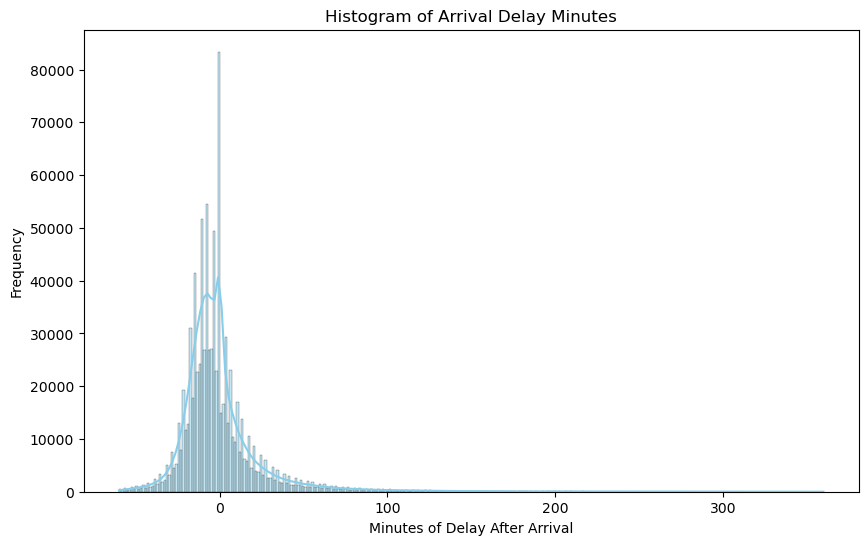

In [48]:

if 'arr_mins_of_delay' in fl.columns and not fl['arr_mins_of_delay'].isnull().any():
    # Configura el tamaño de la figura
    plt.figure(figsize=(10, 6))

    # Crea el histograma usando Seaborn
    sns.histplot(fl['arr_mins_of_delay'], bins=300, kde=True, color='skyblue')

    # Agrega etiquetas y título
    plt.xlabel('Minutes of Delay After Arrival')
    plt.ylabel('Frequency')
    plt.title('Histogram of Arrival Delay Minutes')

    # Muestra el histograma
    plt.show();